# Bayes by Backprop

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

tfk = tf.keras
tfkl = tfk.layers 
tfd = tfp.distributions
tfpl = tfp.layers

print("Tensorflow Version: %s" % tf.__version__)
print("Tensorflow Probability Version: %s" % tfp.__version__)

if tf.test.gpu_device_name() != '/device:GPU:0':
    print('GPU device not found. Using CPU')
else:
    print('Found GPU: {}'.format(tf.test.gpu_device_name()))

C:\Users\Tom\Anaconda3\envs\mltf2\lib\site-packages\ipykernel\parentpoller.py:116: UserWarning: Parent poll failed.  If the frontend dies,
                the kernel may be left running.  Please let us know
                about your system (bitness, Python, etc.) at
                ipython-dev@scipy.org
  ipython-dev@scipy.org""")


Tensorflow Version: 2.0.0-beta1
Tensorflow Probability Version: 0.8.0-dev20190619
Found GPU: /device:GPU:0


In [2]:
# commons package
import os
import sys
import importlib

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import commons as cm
importlib.reload(cm)

<module 'commons' from 'D:\\Tom\\Documents\\gitworkspace\\master\\ml-probability\\tfp_word_embeddings\\commons.py'>

# Configuration and Parameters

In [3]:
# GloVe Configuration

# Directory containing the GloVe files.
GLOVE_DIR = "D:/google drive/haw/master/mastertheisis/hauptprojekt"

# Embedding dimension
EMBEDDING_DIM = 50

In [4]:
imdb = cm.load_imdb()
(x_train, y_train), (x_test, y_test) = imdb

In [5]:
# Bayes by Backprop parameters

# variational layer implementation 
variational_layer, variational_layer_name = [
    (tfpl.DenseFlipout, "DenseFlipout"),
    (tfpl.DenseReparameterization, "DenseReparameterization")
][0]

# hidden layers where each element denotes the number of neurons
n_hidden = [64, 64, 32]

# descriptive model name
model_name = "bayes_by_backprop_%s__%s" % (variational_layer_name, "_".join(map(str, n_hidden)))

# model save file
model_save_file = "./models/%s.h5" % model_name

# history save file
history_save_file = "./history/%s.csv" % model_name

# number of data points
N = x_train.shape[0]

# batch size for training
batch_size = 128

# training epochs 
epochs = 20

# validation split
validation_split = 0.05

# GloVe Word Embedding

In [6]:
# GLOVE Word Embedding
word_index = cm.WordIndex()
embedding_index = cm.load_glove_embedding(GLOVE_DIR, EMBEDDING_DIM)
(embedding_matrix, unknown_words) = word_index.match_glove(embedding_index=embedding_index, embedding_dim=EMBEDDING_DIM)
max_length = cm.get_max_length(x_train, x_test)

Found 400000 word vectors.
17361/88587 unknown words


In [7]:
# pad input vectors
x_train_padded = cm.pad_input(x_train, max_length)
x_test_padded = cm.pad_input(x_test, max_length)

# History

In [12]:
try:
    history_df = pd.read_csv(history_save_file, sep=";", index_col="epoch")
    last_epoch = history_df.index[-1] + 1
    print("Last epoch: %i" % last_epoch)
except FileNotFoundError:
    print("No saved history file")
    last_epoch = 0

Last epoch: 20


# Model

In [9]:
# https://github.com/tensorflow/probability/issues/282

metrics = [
    "acc",
    tfk.metrics.TrueNegatives(name="true_negatives"),
    tfk.metrics.FalseNegatives(name="false_negatives"),
    tfk.metrics.TruePositives(name="true_positives"),
    tfk.metrics.FalsePositives(name="false_positives"),
    tfk.metrics.Precision(name="precision"),
    tfk.metrics.Recall(name="recall"),
    tfk.metrics.KLDivergence(name="kl"),
]

def kernel_divergence_fn(q, p, _):
    return tfd.kl_divergence(q, p) / tf.cast(N * (1 - validation_split), tf.float32)

def create_model():
    model = tfk.Sequential(name="model_%s" % model_name)
    
    model.add(tfkl.Embedding(len(word_index.index) + 1,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=max_length,
                                trainable=False))
    for i in range(len(n_hidden)):
        model.add(variational_layer(n_hidden[i],
                                    activation='relu',
                                    kernel_divergence_fn=kernel_divergence_fn))
    model.add(tfkl.Flatten())
    model.add(variational_layer(1, activation="sigmoid", kernel_divergence_fn=kernel_divergence_fn))
    
    model.compile(optimizer=tfk.optimizers.Adam(0.001), 
                  loss=tfk.losses.binary_crossentropy, 
                  metrics=metrics)
    
    return model

try:
    model = create_model()
    model.load_weights(model_save_file)
    
    # https://github.com/tensorflow/probability/issues/325
    # model = tfk.models.load_model(model_save_file)
    print("using saved model")
except IOError:
    model = create_model()
    print("model has not been trained (IOError)")

model.summary()

using saved model
Model: "model_bayes_by_backprop_DenseFlipout__64_64_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 2697, 50)          4429400   
_________________________________________________________________
dense_flipout (DenseFlipout) (None, 2697, 64)          6464      
_________________________________________________________________
dense_flipout_1 (DenseFlipou (None, 2697, 64)          8256      
_________________________________________________________________
dense_flipout_2 (DenseFlipou (None, 2697, 32)          4128      
_________________________________________________________________
flatten (Flatten)            (None, 86304)             0         
_________________________________________________________________
dense_flipout_3 (DenseFlipou (None, 1)                 172609    
Total params: 4,620,857
Trainable params: 191,457
Non-trainable para

In [10]:
# keras callbacks
csv_logger = tfk.callbacks.CSVLogger(history_save_file, append=True, separator=';')
model_checkpoint_cb = tfk.callbacks.ModelCheckpoint(model_save_file, 
                                                      monitor='val_loss', 
                                                      verbose=0, 
                                                      save_best_only=True, 
                                                      save_weights_only=True, 
                                                      mode='auto')

model.fit(x_train_padded, 
          y_train, 
          validation_split=validation_split,
          initial_epoch=last_epoch,
          epochs=epochs, 
          batch_size=batch_size,
          callbacks=[csv_logger, model_checkpoint_cb])

W0620 16:57:37.192709 13152 deprecation.py:323] From C:\Users\Tom\Anaconda3\envs\mltf2\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 23750 samples, validate on 1250 samples
Epoch 17/20
23750/23750 [==============================] - 36s 1ms/sample - loss: 2.6964 - acc: 0.8457 - true_negatives: 9900.0000 - false_negatives: 1691.0000 - true_positives: 10185.0000 - false_positives: 1974.0000 - precision: 0.8377 - recall: 0.8576 - kl: 0.1764 - val_loss: 2.5773 - val_acc: 0.8232 - val_true_negatives: 540.0000 - val_false_negatives: 135.0000 - val_true_positives: 489.0000 - val_false_positives: 86.0000 - val_precision: 0.8504 - val_recall: 0.7837 - val_kl: 0.2727
Epoch 18/20
23750/23750 [==============================] - 33s 1ms/sample - loss: 2.3476 - acc: 0.8483 - true_negatives: 9921.0000 - false_negatives: 1650.0000 - true_positives: 10226.0000 - false_positives: 1953.0000 - precision: 0.8396 - recall: 0.8611 - kl: 0.1763 - val_loss: 2.2389 - val_acc: 0.8408 - val_true_negatives: 518.0000 - val_false_negatives: 91.0000 - val_true_positives: 533.0000 - val_false_positives: 108.0000 - val_precision: 0.8315 - val

In [13]:
def plot_confidence(means, stddevs, true_ys):
    x = np.arange(0, len(means), 1)
    y = means
    yerr = np.array(stddevs) * 2

    fig, ax = plt.subplots()
    plt.xlabel("movie")
    plt.ylabel("predicted probability")
    
    ax.hlines(y=[0, 0.5, 1], xmin=0, xmax=len(x) - 1, linewidth=1, linestyle=":", color=["black", "gray", "black"])
    ax.errorbar(x, y, yerr=yerr, fmt="o", elinewidth=1, color="black")
    ax.errorbar(x, true_ys, fmt="x", color="r")
    plt.show()
    
def plot_metric(name, history_df):
    plt.plot(history_df[name])
    plt.plot(history_df["val_%s" % name])
    plt.title('Model %s' % name)
    plt.ylabel(name)
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

In [14]:
loss, accuracy, *other = model.evaluate(x_test_padded, y_test)
print("Test loss: %.2f\nTest accuracy: %.2f%%" % (loss, accuracy * 100))

25000/25000 [==============================] - 32s 1ms/sample - loss: 1.7932 - acc: 0.8292 - true_negatives: 10095.0000 - false_negatives: 1866.0000 - true_positives: 10634.0000 - false_positives: 2405.0000 - precision: 0.8156 - recall: 0.8507 - kl: 0.1912
Test loss: 1.79
Test accuracy: 82.92%


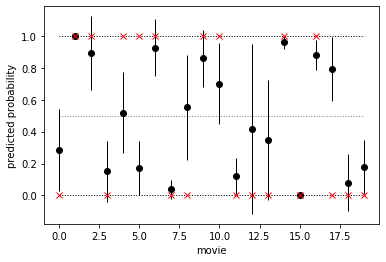

In [15]:
n = 20
samples = 75

y_pred = [model.predict(x_test_padded[:n]) for i in range(samples)]
y_pred = np.array(y_pred)

means = [np.mean(y_pred[:, i]) for i in range(n)]
stddevs = [np.std(y_pred[:, i]) for i in range(n)]
plot_confidence(means, stddevs, y_test[:n])

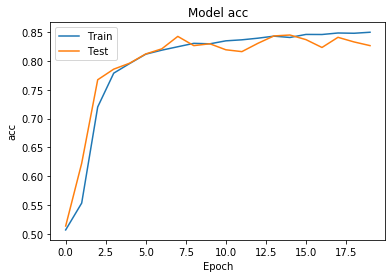

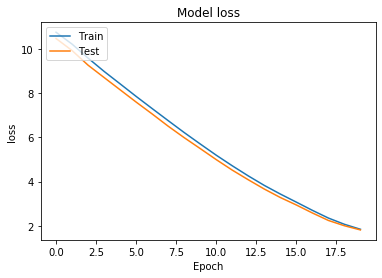

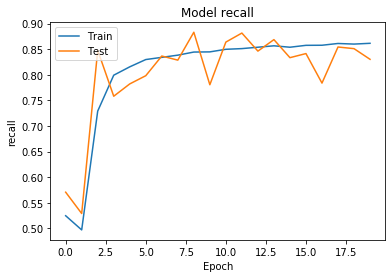

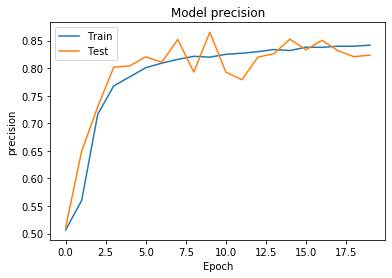

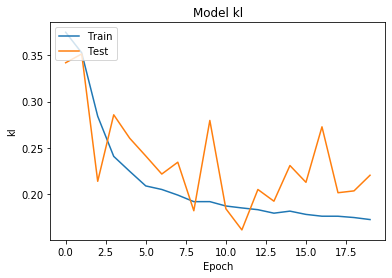

In [16]:
for metric in ["acc", "loss", "recall", "precision", "kl"]:
    plot_metric(metric, history_df)